In [1]:
#IMPORTS 
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(r"C:\Users\DGaard\Desktop\Gits\MoleculeSim\ownSim")
#sys.path.append(r"C:\Users\EmilR\Documents\GitHub\MoleculeSim\ownSim")

#import forces as fc
import molecules as mc
import img3dto2d as i32
import util
#import random
#import copy
#from tqdm import tqdm

#mayavi imports:
from __future__ import absolute_import, division, print_function
from mayavi import mlab
import math

#stats:
import stats as st
from tqdm import tqdm

#video imports 
sys.path.append(r"C:\Users\DGaard\Desktop\Gits\MoleculeSim\videoStuff")
import video_format as vf
from skimage.transform import resize, rescale
from skimage.morphology import label

********************************************************************************
         to build the TVTK classes (9.2). This may cause problems.
         Please rebuild TVTK.
********************************************************************************



# File for loading multiple simulations and looking at their RSM

In [2]:
class SimData: #used as culmination of simTestV4 but for multiple images
  def __init__(self,filename,zdepth = 1000):
    #molecule data
    points, radii, acc = mc.load_molecule_steps(filename)
    self.points = points
    self.radii = radii
    self.acc = acc
    
    #other data
    filename_split = filename.split("_")
    self.num_frames = int(filename_split[1])
    self.num_molecules = len(points[0])
    self.size_const = int(filename_split[2])
    self.seed = int(filename_split[3])
    self.max_stepsize = int(filename_split[4]) 
    self.skip_frames = int(filename_split[5])
    self.box_size = np.array([self.size_const,self.size_const,zdepth])
    self.image_size = np.array([self.size_const,self.size_const])

    #density
    box_vol = int(self.box_size[0])*int(self.box_size[1])*int(self.box_size[2])
    sphere_vol = 0
    for r in radii:
      sphere_vol += ((4/3)*r**3*np.pi)
    self.density = sphere_vol/box_vol

    #image processing data
    self.frame_imgs = []
    self.th_imgs = []

  def add_frame(self,frame_nr,img_fill,img_gauss,img_fill_smooth):
    self.frame_imgs.append([frame_nr,img_fill,img_gauss,img_fill_smooth])
  
  def add_threshold(self,frame_nr,th_img):
    self.th_imgs.append([frame_nr,th_img])

  
  def __str__(self):
    return "total frames: " +  str(self.num_frames * self.skip_frames) +  " stored frames: " + str(self.num_frames) + " molecules: "  + str(self.num_molecules) +  " image size: " + str(self.image_size) + " seed: " +str(self.seed)+ " max stepsize: " + str(self.max_stepsize) + " Density: " + str(self.density)



In [3]:
#collections of simulations:

#step 5, same size higher / lower vol frac:
# 3% - simV3R_500_4000_214142_5_1000_75dfb.npy
# 6% - simV3R_500_4000_214142_5_1000_f95f1.npy
# 13% - 
# simulations = ["simV3R_500_4000_214142_5_1000_75dfb.npy", "simV3R_500_4000_214142_5_1000_f95f1.npy"]


#1 stepsize 500_000 different seeds
# 1414 - simV3R_500_8000_1414_1_1000_09965.npy
# 1416 - simV3R_500_8000_1416_1_1000_5d9a5.npy
# 1417 - simV3R_500_8000_1417_1_1000_bf0b5.npy
# simulations = ["simV3R_500_8000_1414_1_1000_09965.npy", "simV3R_500_8000_1416_1_1000_5d9a5.npy", "simV3R_500_8000_1417_1_1000_bf0b5.npy"]


#5 stepsize 500_000 different seeds
# 1414 - simV3R_500_8000_1414_5_1000_7c3ec.npy
# 1416 - simV3R_500_8000_1416_5_1000_de4ee.npy
# 1417 - simV3R_500_8000_1417_5_1000_42849.npy


# xxxx - 

In [4]:
simulations = ["simV3R_500_8000_1414_5_1000_7c3ec.npy", "simV3R_500_8000_1416_5_1000_de4ee.npy", "simV3R_500_8000_1417_5_1000_42849.npy"]
sim_data = [SimData(s) for s in simulations]

for i in sim_data:
  print(i)

total frames: 500000 stored frames: 500 molecules: 1037 image size: [8000 8000] seed: 1414 max stepsize: 5 Density: 0.11550780497515023
total frames: 500000 stored frames: 500 molecules: 1037 image size: [8000 8000] seed: 1416 max stepsize: 5 Density: 0.13529552045462195
total frames: 500000 stored frames: 500 molecules: 1037 image size: [8000 8000] seed: 1417 max stepsize: 5 Density: 0.12452744444777754


2it [02:36, 78.36s/it]00:00<?, ?it/s]


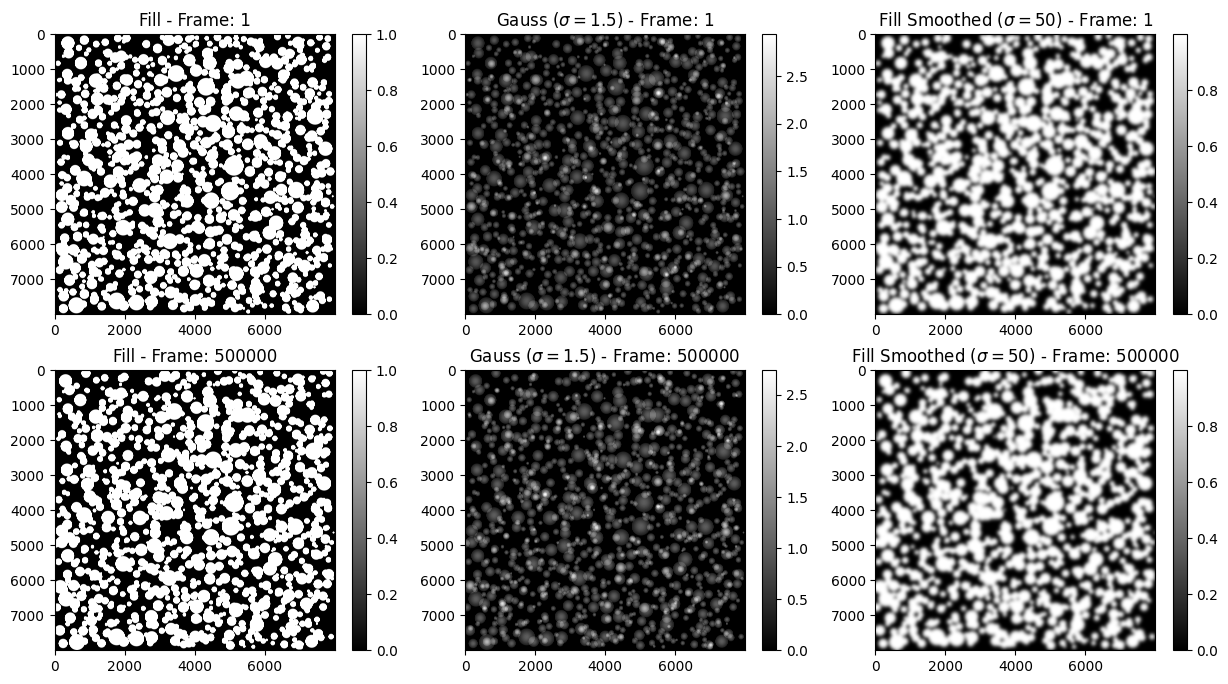

2it [02:48, 84.34s/it]02:42<05:24, 162.18s/it]


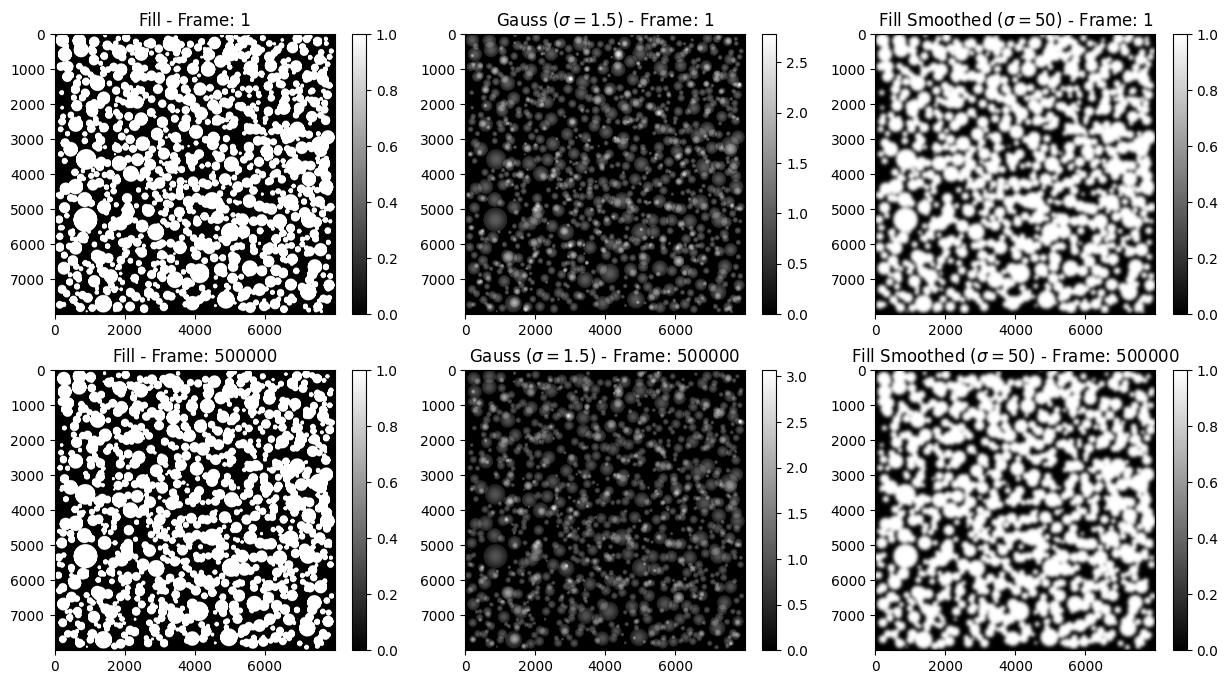

2it [02:44, 82.07s/it]05:36<02:49, 169.17s/it]


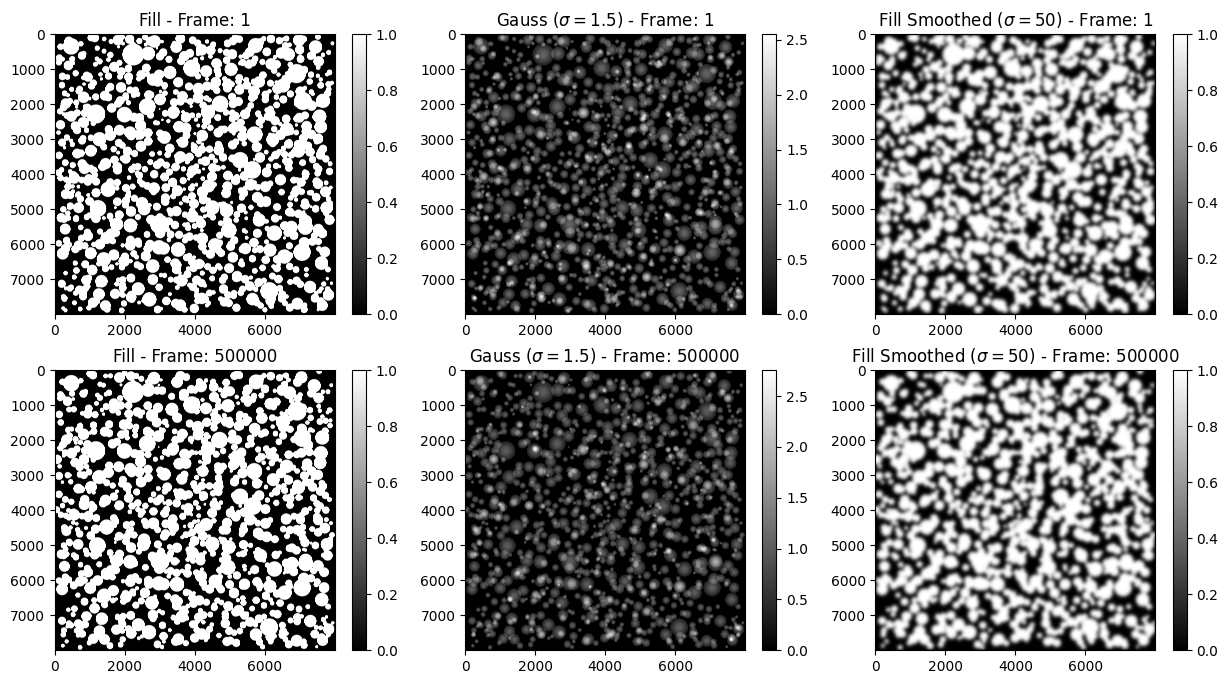

100%|██████████| 3/3 [08:25<00:00, 168.58s/it]


In [5]:
#get initial/end frame images
frames = ["first","last"]
sigma_scale = 1.5
sigma_smooth = 50

for sd in tqdm(sim_data):
  #make sure no images are stored (in case of re run)
  sd.frame_imgs = []


  plt.figure(figsize=(15,4*len(frames)))
  for i,f in tqdm(enumerate(frames)):
    _frame_val = 0
    _frame_id = 0

    if f == "first":
      _frame_val = 1
      _frame_id = 0
    else:
      _frame_id = len(sd.points)-1
      _frame_val = (_frame_id + 1) * sd.skip_frames

    _p2dr = list(zip(np.array(sd.points[_frame_id])[:,:2],sd.radii)) # all depths

    #Hard fill
    plt.subplot(len(frames),3,(i)*3+1)
    plt.title(f"Fill - Frame: {_frame_val}")
    _img_fill = i32.get_3d_to_2d_img(_p2dr,sd.image_size)

    im_ratio = _img_fill.shape[0]/_img_fill.shape[1]
    plt.imshow(_img_fill,cmap="gray")
    plt.colorbar(fraction=0.045 * im_ratio)

    #gauss fill
    plt.subplot(len(frames),3,(i)*3+2)
    plt.title(f"Gauss ($\sigma =${sigma_scale}) - Frame: {_frame_val}")
    _img_gauss = i32.get_3d_to_2d_img_gauss(_p2dr,sd.image_size,sigma_scale)
    plt.imshow(_img_gauss,cmap="gray")
    plt.colorbar(fraction=0.045 * im_ratio)

    #gauss on hard fill:
    plt.subplot(len(frames),3,(i)*3+3)
    plt.title(f"Fill Smoothed ($\sigma =${sigma_smooth}) - Frame: {_frame_val}")
    _img_smooth = i32.gauss2dimg(_img_fill,sigma_smooth)
    plt.imshow(_img_smooth,cmap="gray")
    plt.colorbar(fraction=0.045 * im_ratio)

    sd.add_frame(_frame_val,_img_fill,_img_gauss,_img_smooth)
  
  plt.show()



  0%|          | 0/3 [00:00<?, ?it/s]

total frames: 500000 stored frames: 500 molecules: 1037 image size: [8000 8000] seed: 1414 max stepsize: 5 Density: 0.11550780497515023
5 5


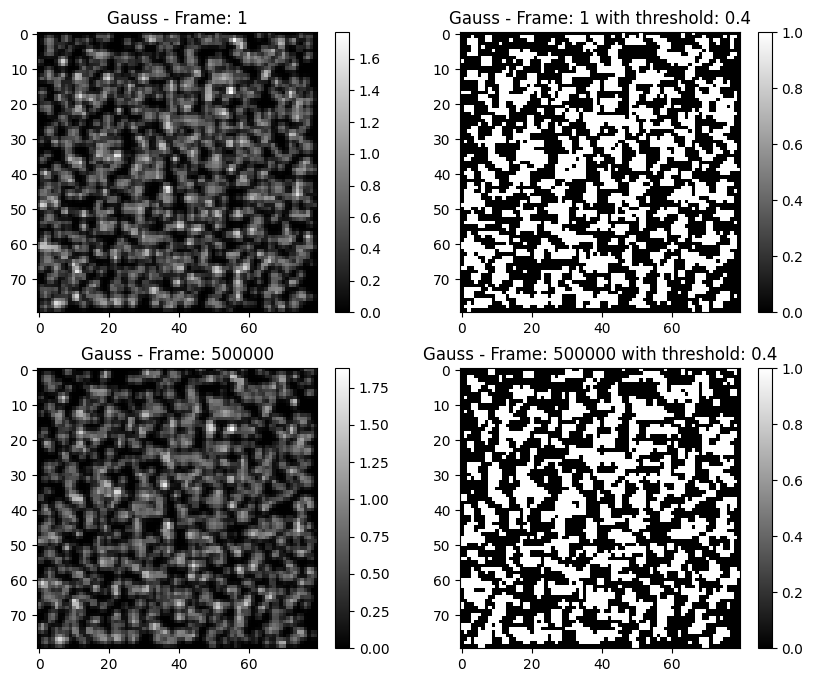

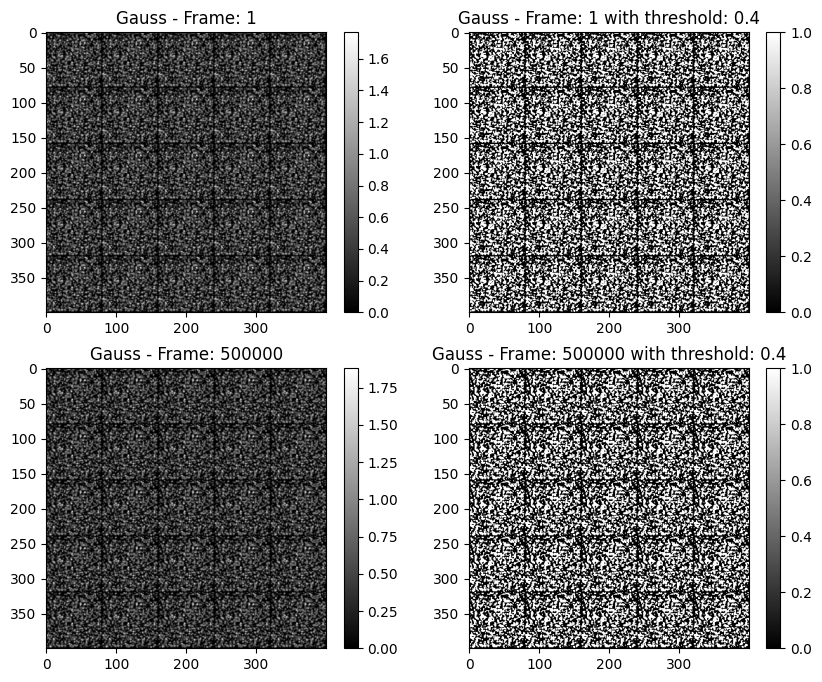

 33%|███▎      | 1/3 [00:21<00:43, 21.70s/it]

total frames: 500000 stored frames: 500 molecules: 1037 image size: [8000 8000] seed: 1416 max stepsize: 5 Density: 0.13529552045462195
5 5


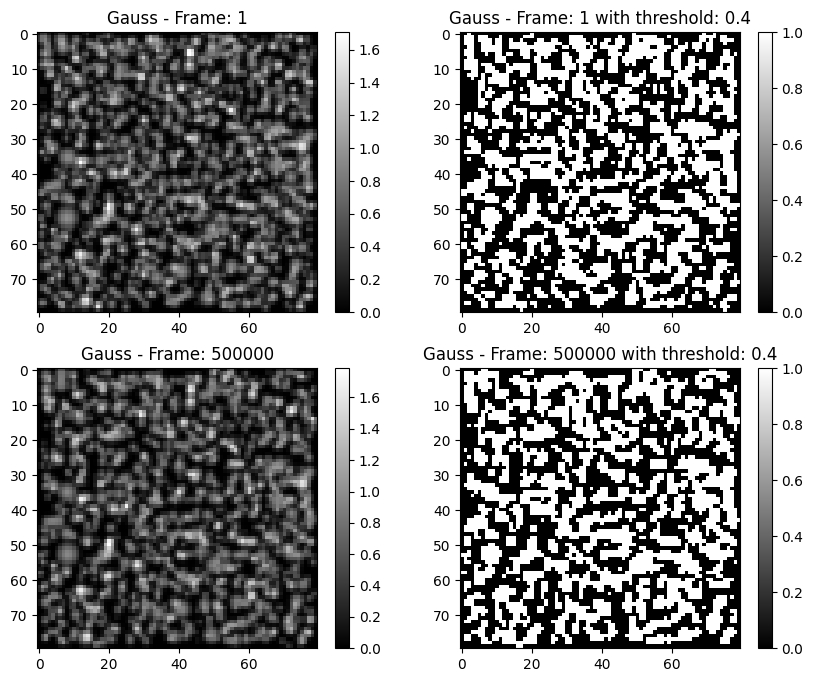

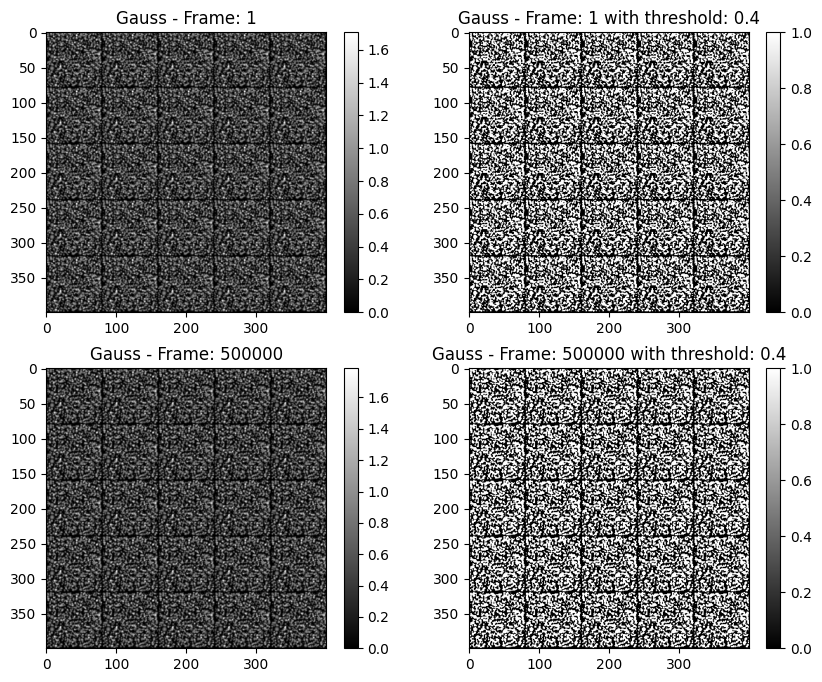

 67%|██████▋   | 2/3 [00:43<00:21, 21.82s/it]

total frames: 500000 stored frames: 500 molecules: 1037 image size: [8000 8000] seed: 1417 max stepsize: 5 Density: 0.12452744444777754
5 5


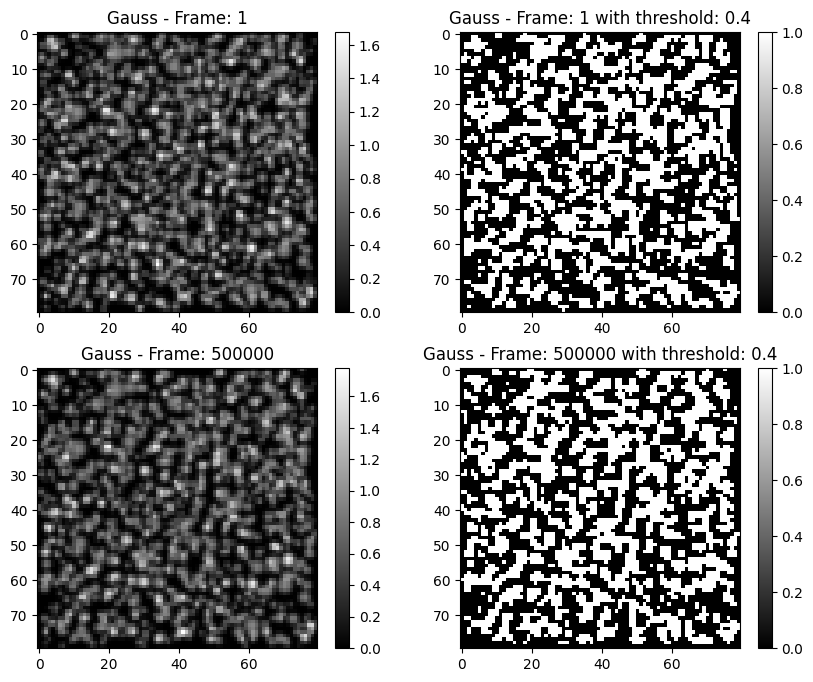

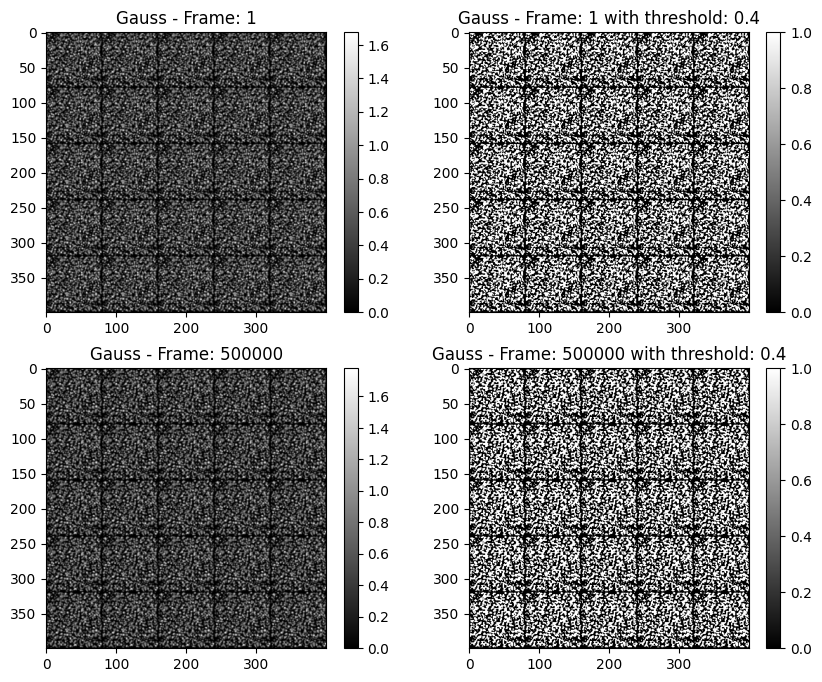

100%|██████████| 3/3 [01:05<00:00, 21.76s/it]


In [6]:
#represent image in microscope scale 

def process_our_image(img):
  #need to smooth?
  #remove boarder?
  return label(img)

L= 50
threshold = 0.4
wanted_image_size = np.array([400,400]) #video size

for sd in tqdm(sim_data):
  print(sd)
  #reset the thresholded image incase of previous run
  sd.th_imgs = []

  scaled_img_size = np.array([sd.box_size[0]/100,sd.box_size[1]/100]) #1 pixel in original video is 100 nm

  dupX = int(wanted_image_size[1]/scaled_img_size[1])
  dupY = int(wanted_image_size[0]/scaled_img_size[0])
  print(dupX,dupY)
  #0 = frame val, 1, 2 or 3 = fill, gauss, smooth fill
  imgs_frame_vals = [sd.frame_imgs[i][0] for i in range(len(sd.frame_imgs))]
  imgs_for_threshold = [sd.frame_imgs[i][2] for i in range(len(sd.frame_imgs))]

  image_frames = [resize(i,scaled_img_size) for i in imgs_for_threshold]
  image_frames_duplicated = [i32.duplicate_image(img,dupX,dupY) for img in image_frames]

  plt.figure(figsize=(10,4*len(image_frames)))
  for i,img in enumerate(image_frames):
    
    _frame_val = imgs_frame_vals[i]

    plt.subplot(len(image_frames),2,(i)*2+1)
    plt.title(f"Gauss - Frame: {_frame_val}")
    plt.imshow(img,cmap="gray")

    im_ratio = img.shape[0]/img.shape[1]
    plt.colorbar(fraction=0.045 * im_ratio)

    plt.subplot(len(image_frames),2,(i)*2+2)
    plt.title(f"Gauss - Frame: {_frame_val} with threshold: {threshold}")
    _img_gauss_th = np.where(img > threshold,1,0)
    plt.imshow(_img_gauss_th,cmap="gray")
    plt.colorbar(fraction=0.045 * im_ratio)

    #th_imgs.append(_img_gauss_th)
  plt.show()

  plt.figure(figsize=(10,4*len(image_frames)))
  for i,img in enumerate(image_frames_duplicated):#enumerate(image_frames):

    _frame_val = imgs_frame_vals[i]

    plt.subplot(len(image_frames),2,(i)*2+1)
    plt.title(f"Gauss - Frame: {_frame_val}")
    plt.imshow(img,cmap="gray")

    im_ratio = img.shape[0]/img.shape[1]
    plt.colorbar(fraction=0.045 * im_ratio)

    plt.subplot(len(image_frames),2,(i)*2+2)
    plt.title(f"Gauss - Frame: {_frame_val} with threshold: {threshold}")
    _img_gauss_th = np.where(img > threshold,1,0)
    plt.imshow(_img_gauss_th,cmap="gray")
    plt.colorbar(fraction=0.045 * im_ratio)

    sd.add_threshold(_frame_val,process_our_image(_img_gauss_th))
  plt.show()


In [7]:
[sim_data[0].frame_imgs[i][0] for i in range(len(sim_data[0].frame_imgs))]

[1, 500000]

In [8]:
import numpy as np
# import imageio
import matplotlib.pyplot as plt
from matplotlib import cm
from skimage.color import label2rgb
from IPython.display import display, clear_output


def visualize2(video, F_list, G_list, F_noise=np.array([]), G_noise=np.array([]), L=100, save=False,frame_name = "-1"):
    """Visualizes a list of data overlaps, can compare with one dataset"""
    fig, ax = plt.subplots(1,4, figsize=(14,6), gridspec_kw={'width_ratios': [1, 1, 1, 2]})
    plt.tight_layout()
    plt.title('Cheese gel video frames')
    colors = cm.Blues(np.linspace(0.2, 1, len(video)))

    # a = int(168 / len(video))

    for i in range(len(F_list)):
        M = video[i].shape[0] - L
        bx = (L, M, M, L, L)
        by = (L, L, M, M, L)

        ax[3].plot(bx, by, '-r')
        ax[3].imshow(label2rgb(video[i], bg_label=0))
        # ax[3].set_title('frame nr.{}'.format(a * (i+1)))
        if frame_name == "-1":
            ax[3].set_title('frame nr.{}'.format(i+1))
        else:
            ax[3].set_title(f'frame nr. {frame_name}')

        ax[0].set_title('Area overlap')
        ax[0].plot(F_list[i], color=colors[i])
        ax[0].set_xlabel('r')
        ax[0].set_ylabel('area overlap')

        ax[1].set_title('Fractional area overlap')
        ax[1].plot(F_list[i]/G_list[i], color=colors[i])
        ax[1].set_xlabel('r')
        ax[1].set_ylabel('fractional area overlap')

        ax[2].set_title('Curve overlap')
        ax[2].plot((F_list[i])[1:]-(F_list[i])[:-1], color=colors[i])
        ax[2].set_xlabel('r')
        ax[2].set_ylabel('curve overlap')

        if save:
            # filename = 'frames/subplot_{:03d}.png'.format(a * (i+1))
            filename = 'frames/subplot_{:03d}.png'.format(i+1)
            fig.savefig(filename)
            # plots.append(fig)

        #clear_output(wait = True)

    if F_noise.size and G_noise.size:
        ax[0].plot(F_noise, color='r')
        ax[1].plot(F_noise/G_noise, color='r')
        ax[2].plot(F_noise[1:]-F_noise[:-1], color='r')

    if save:
        # filename = 'frames/subplot_{:03d}.png'.format(a * (i+1))
        filename = 'frames/subplot_{:03d}.png'.format(i+1)
        fig.savefig(filename)
        # plots.append(fig)

        # with imageio.get_writer('animation.gif', mode='I') as writer:
        #     for plot in plots:
        #         writer.append_data(imageio.core.image_as_uint(plot.canvas.renderer.buffer_rgba()))
    plt.show()


total frames: 500000 stored frames: 500 molecules: 1037 image size: [8000 8000] seed: 1414 max stepsize: 5 Density: 0.11550780497515023


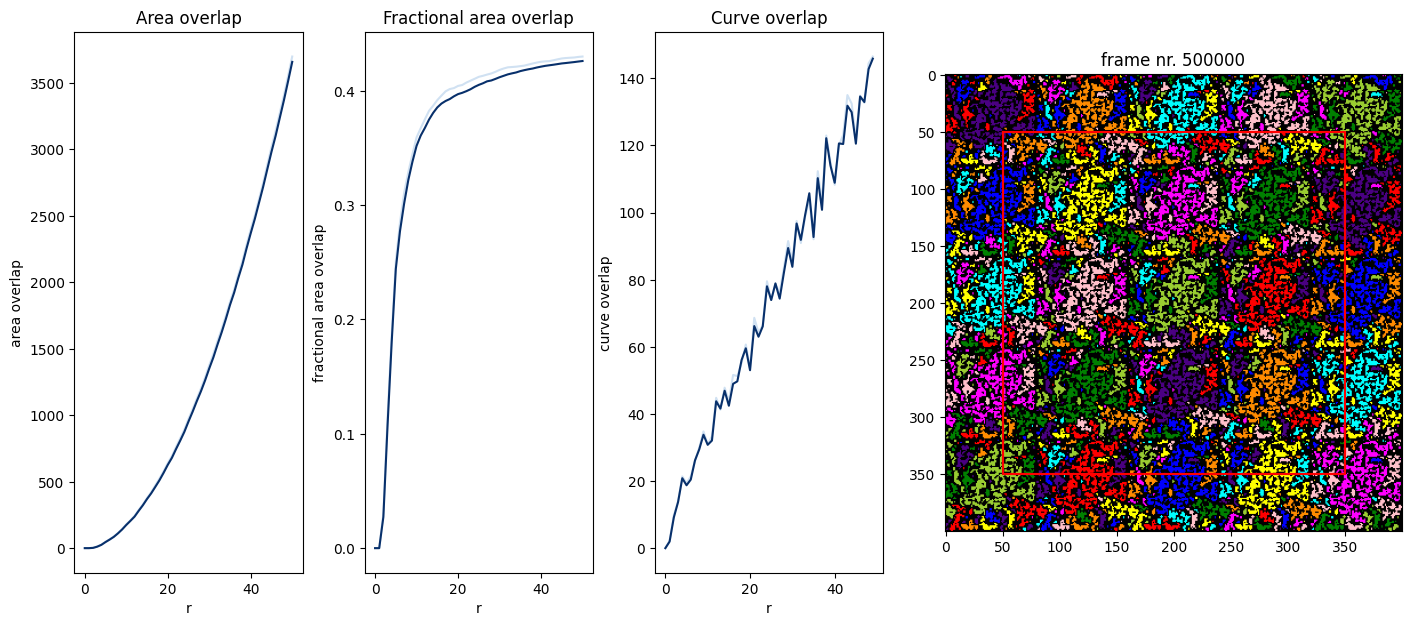

total frames: 500000 stored frames: 500 molecules: 1037 image size: [8000 8000] seed: 1416 max stepsize: 5 Density: 0.13529552045462195


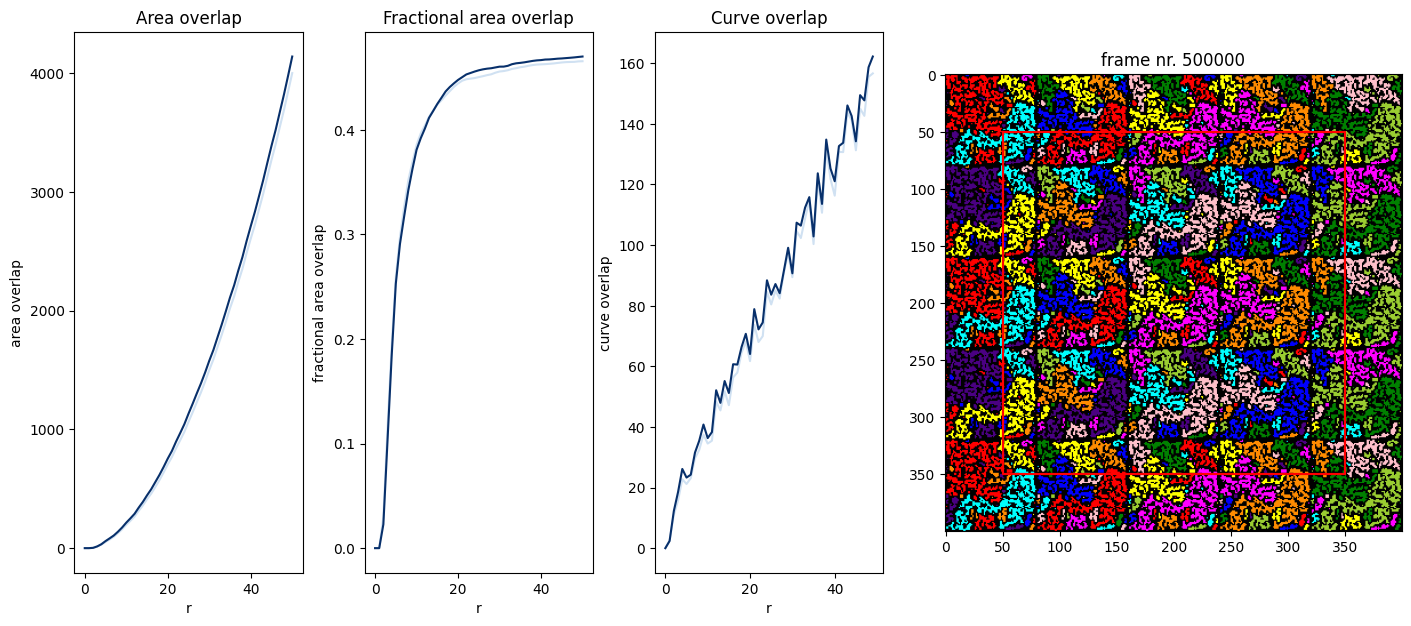

total frames: 500000 stored frames: 500 molecules: 1037 image size: [8000 8000] seed: 1417 max stepsize: 5 Density: 0.12452744444777754


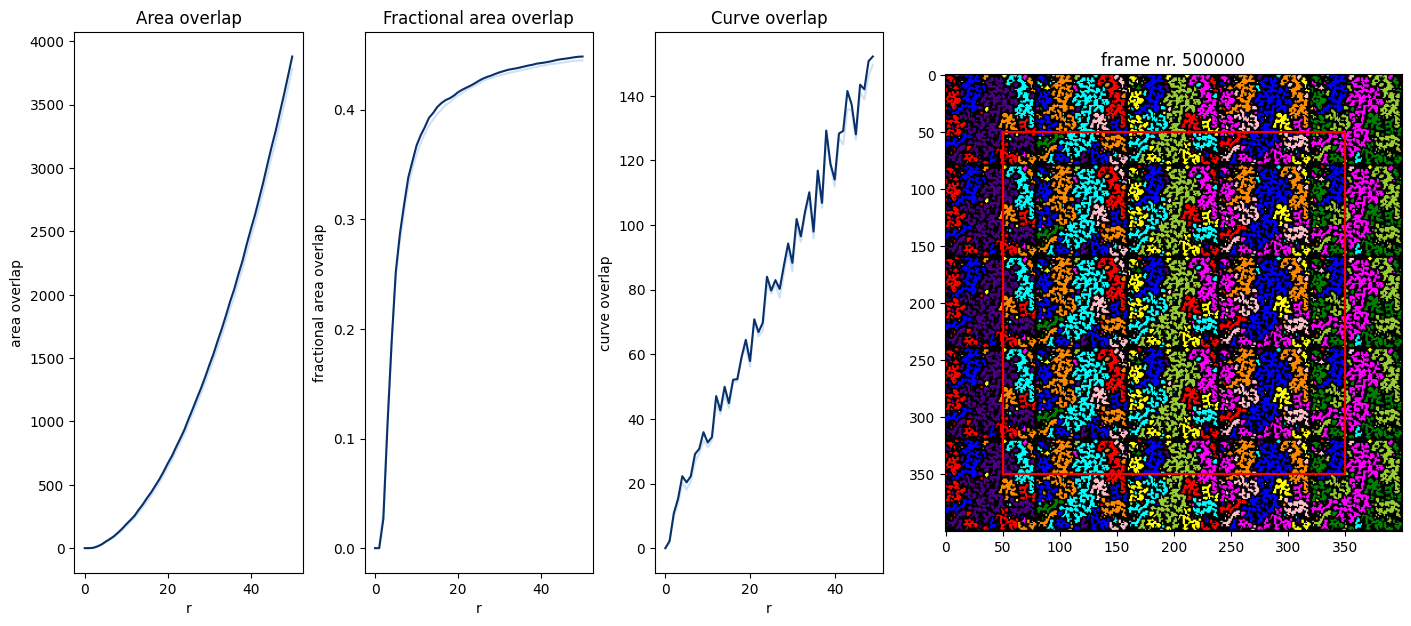

In [9]:
#process the images and produce relational shape measures:
full_F_list = []
full_G_list = []
final_frame = 0

for sd in sim_data:
  print(sd)
  cc_imgs = [sd.th_imgs[i][1] for i in range(len(sd.th_imgs))]
  final_frame = sd.th_imgs[-1][0]
  F_list, G_list = vf.analyse_video(cc_imgs,L=L)

  full_F_list.append(F_list)
  full_G_list.append(G_list)

  visualize2(cc_imgs,F_list,G_list, save=False,L=L,frame_name=final_frame)


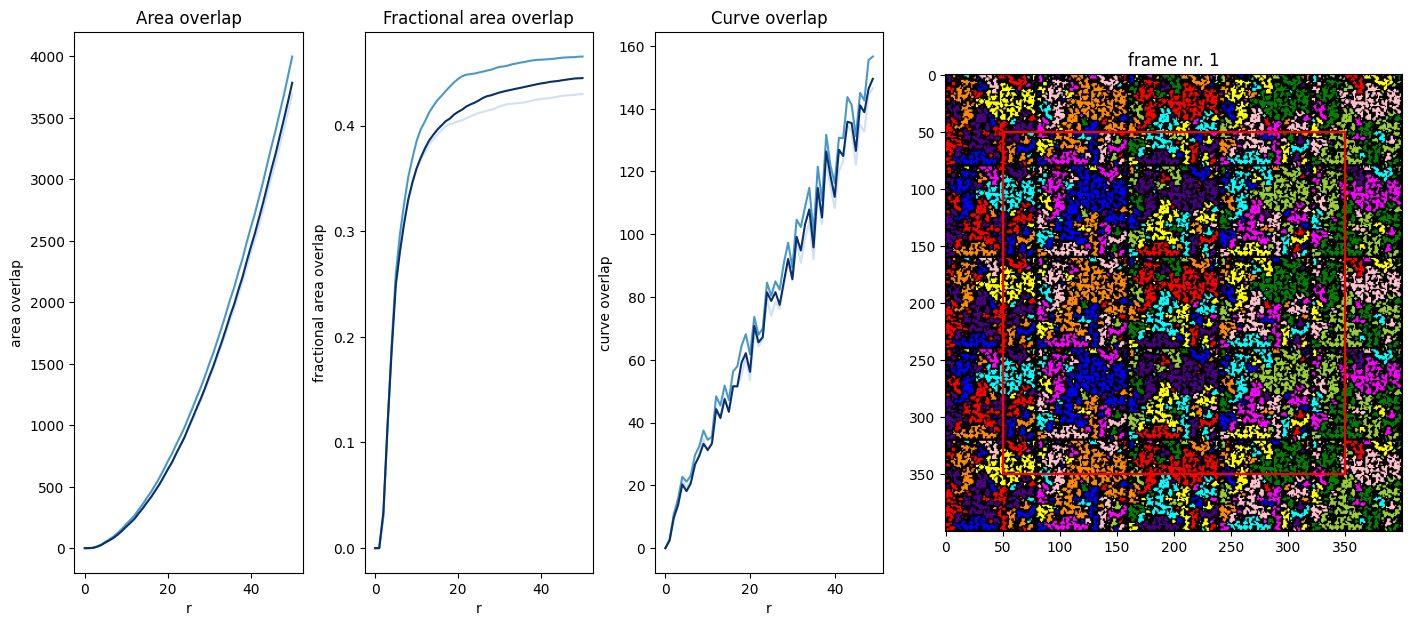

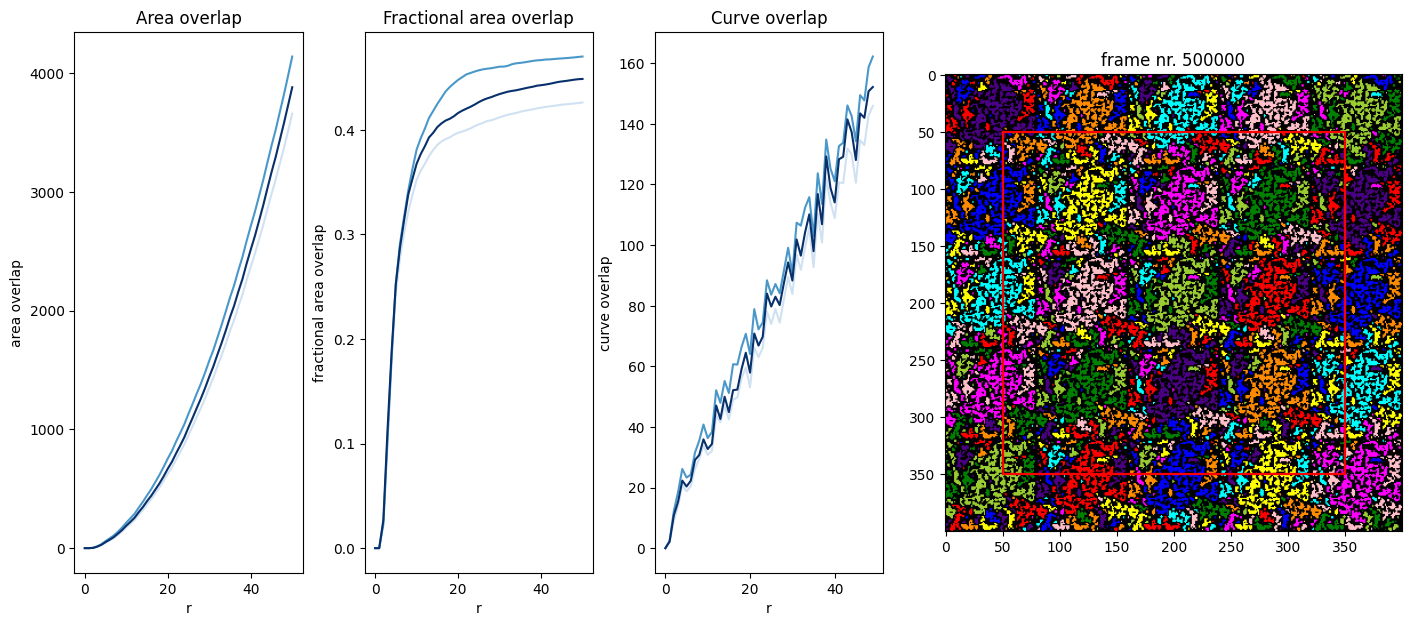

In [10]:
#visualize area RSM for a single frame a time
for i in range(len(sim_data[0].th_imgs)):
  #extracted from first simulation
  frame_name = sim_data[0].th_imgs[i][0]
  test_imgs = [sim_data[0].th_imgs[i][1] for _ in range(len(full_F_list))]
  cur_F_list = [x[i] for x in full_F_list]
  cur_G_list = [x[i] for x in full_G_list]
  visualize2(test_imgs,cur_F_list,cur_G_list,L=L,frame_name=frame_name)


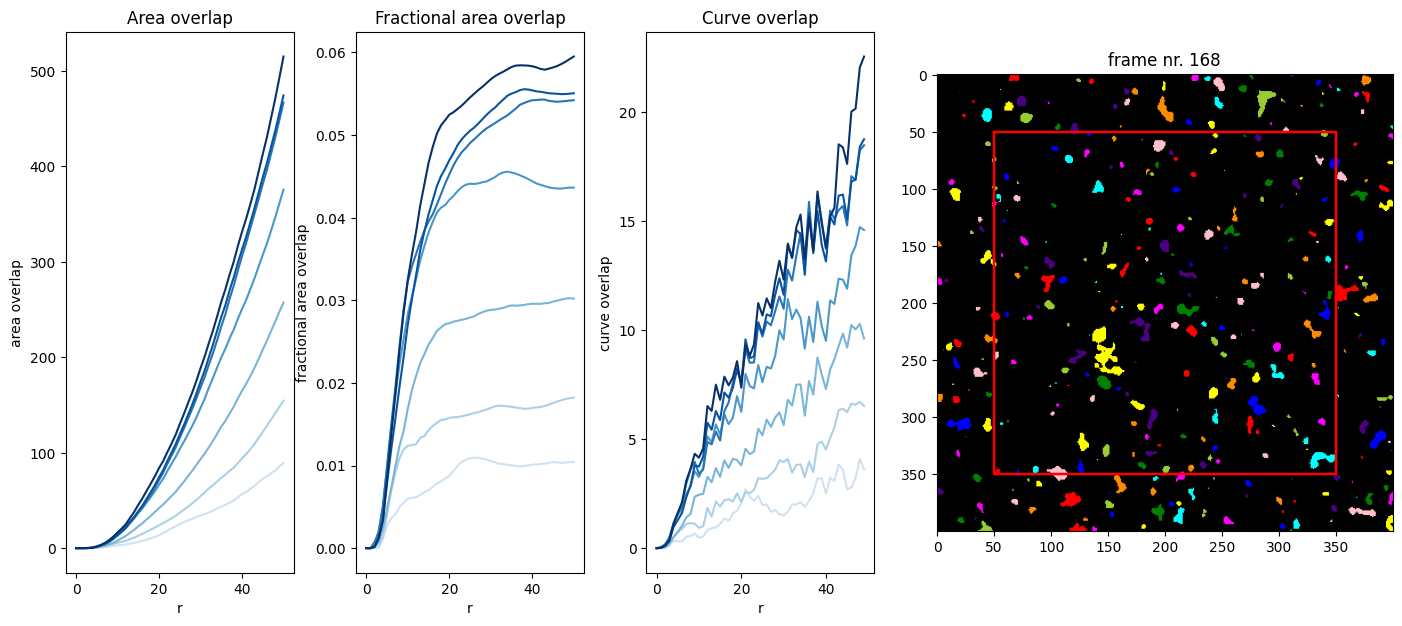

In [11]:
#their video for comparison
#info from the video:
threshold2 = 0.3
smooth = 1
skip_size = 24
size = int(wanted_image_size[0])

endframe_offset = 7
frames_240= vf.process_video(vf.VIDEO_PATH,threshold=threshold2,smooth=smooth,skip_size=skip_size,size=size)
used_frame = frames_240[:endframe_offset]

F_list2, G_list2 = vf.analyse_video(used_frame,L=L)

#frames_240= vf.process_video(vf.VIDEO_PATH,threshold=threshold,smooth=smooth,skip_size=skip_size,size=size)
print(len(frames_240))
vf.visualize(used_frame,F_list2,G_list2,L=L,frame_name=endframe_offset*skip_size)